In [118]:
import h5py
import torch
import logging
import numpy as np

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Tuple, List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import torchvision.transforms.functional as F

from torchvision.models import resnet18, ResNet18_Weights

In [94]:
logging.basicConfig(format="[%(asctime)s:%(levelname)s]: %(message)s")

In [174]:
class PatchCamelyonDataset(Dataset):
    def __init__(self, data_path: str, targets_path: str, transform=None) -> None:
        self.data = h5py.File(data_path)["x"]
        self.targets = h5py.File(targets_path)["y"]
        self.transform = transform

    def __len__(self) -> int:
        return self.targets.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        sample = torch.tensor(self.data[idx, :, :, :]).float() / 255.0
        # [channels, x, y] to [x, y, channels]
        sample = torch.permute(sample, (2, 0, 1))

        # We need to squeeze the targets as they are
        # nested within multiple arrays
        target = torch.tensor(self.targets[idx].squeeze())

        if self.transform:
            sample = self.transform(sample)
        
        return sample, target

In [175]:
def show(imgs: List[torch.tensor] | torch.tensor):
    if type(imgs) != list:
        imgs = [imgs]
    
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)

        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [190]:
train_dataset = PatchCamelyonDataset(
    data_path="data/camelyonpatch_level_2_split_train_x.h5",
    targets_path="data/camelyonpatch_level_2_split_train_y.h5",
    transform=transforms.Resize(224, antialias=True)
)

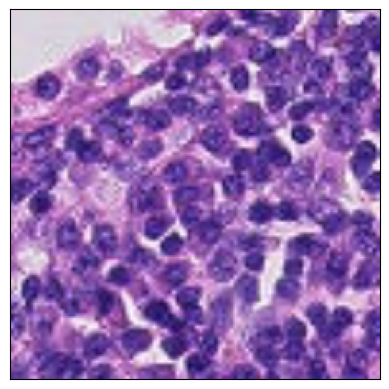

In [191]:
sample, target = train_dataset[0]
show(sample)

In [192]:
def train_epoch(
    model: nn.Module,
    device: torch.device,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    loss_fn: nn.Module
):
    model.train()

    for _, (images, targets) in enumerate(tqdm(train_loader)):
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()

        preds = model(images)

        loss = loss_fn(preds, targets)
        loss.backward()

        optimizer.step()

In [228]:
def test(
    model: nn.Module,
    device: torch.device,
    test_loader: DataLoader
):
    model.eval()
    test_loss, correct_preds = 0, 0

    with torch.no_grad():
        for _, (images, targets) in enumerate(tqdm(test_loader)):
            images, targets = images.to(device), targets.to(device)

            preds = model(images)
            test_loss += loss_fn(preds, targets)

            preds = preds.argmax(1)
            correct_preds += (preds == targets).sum()

    test_loss /= len(test_loader.dataset)
    accuracy = correct_preds / len(test_loader.dataset)

    return test_loss, accuracy

In [208]:
loss_fn = nn.CrossEntropyLoss()
model = resnet18(weights=ResNet18_Weights.DEFAULT)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [209]:
# Are we only training the last layer?
model.fc = nn.Linear(in_features=512, out_features=2)

In [229]:
test_loss, accuracy = test(
    model=model,
    device=torch.device("cpu"),
    test_loader=train_loader
)

  0%|                                                                | 4/8192 [00:04<2:26:10,  1.07s/it]


KeyboardInterrupt: 